In [1]:
%pip install xgboost imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

sns.set_style("whitegrid")
%matplotlib inline



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the CVA data
file_path = '../data/joints/cva_data/output/final_data.csv'
df = pd.read_csv(file_path)

# Remove LDL direct | Instance 1 column
df = df.drop(columns=['LDL direct | Instance 1'], errors='ignore')

df.head()


,Participant ID,"TNNI3;Troponin I, cardiac muscle",IL6;Interleukin-6,GDF15;Growth/differentiation factor 15,FGA;Fibrinogen alpha chain,VWF;von Willebrand factor,IL1B;Interleukin-1 beta,IL10;Interleukin-10,C3;Complement C3,C1QTNF1;Complement C1q tumor necrosis factor-related protein 1,...,Gamma glutamyltransferase | Instance 0,Glucose | Instance 0,Glycated haemoglobin (HbA1c) | Instance 0,HDL cholesterol | Instance 0,IGF-1 | Instance 0,Rheumatoid factor | Instance 0,Testosterone | Instance 0,Total bilirubin | Instance 0,Triglycerides | Instance 0,label
0,4501495,NaN,-0.1419,1.69175,0.1397,1.40520,-0.3262,0.9875,-0.3479,-0.23015,...,9.1,4.422,30.2,1.631,22.226,NaN,NaN,3.16,0.971,Ischemic Stroke
1,2328248,0.5271,0.3676,0.10775,-0.2744,0.19150,0.1260,0.0469,0.1015,-0.17955,...,65.5,4.714,34.0,1.257,21.985,13.2,10.395,7.48,1.164,Ischemic Stroke
2,2593363,-0.1366,-0.5021,0.11135,-0.5386,-1.78270,0.8271,-0.0619,-0.7343,-0.52525,...,18.3,NaN,34.8,NaN,18.407,NaN,0.941,8.39,1.720,Ischemic Stroke
3,1413344,-0.0054,1.7543,0.26705,0.1087,-0.38055,0.6683,0.1442,2.3266,0.01830,...,16.1,5.168,44.5,1.122,16.238,NaN,1.323,9.55,1.322,Ischemic Stroke
4,4063286,-1.5246,0.5630,-0.00175,0.2521,1.42260,0.7743,0.9250,0.1251,0.42270,...,31.9,5.079,38.7,0.867,20.477,NaN,6.985,9.36,2.079,Ischemic Stroke


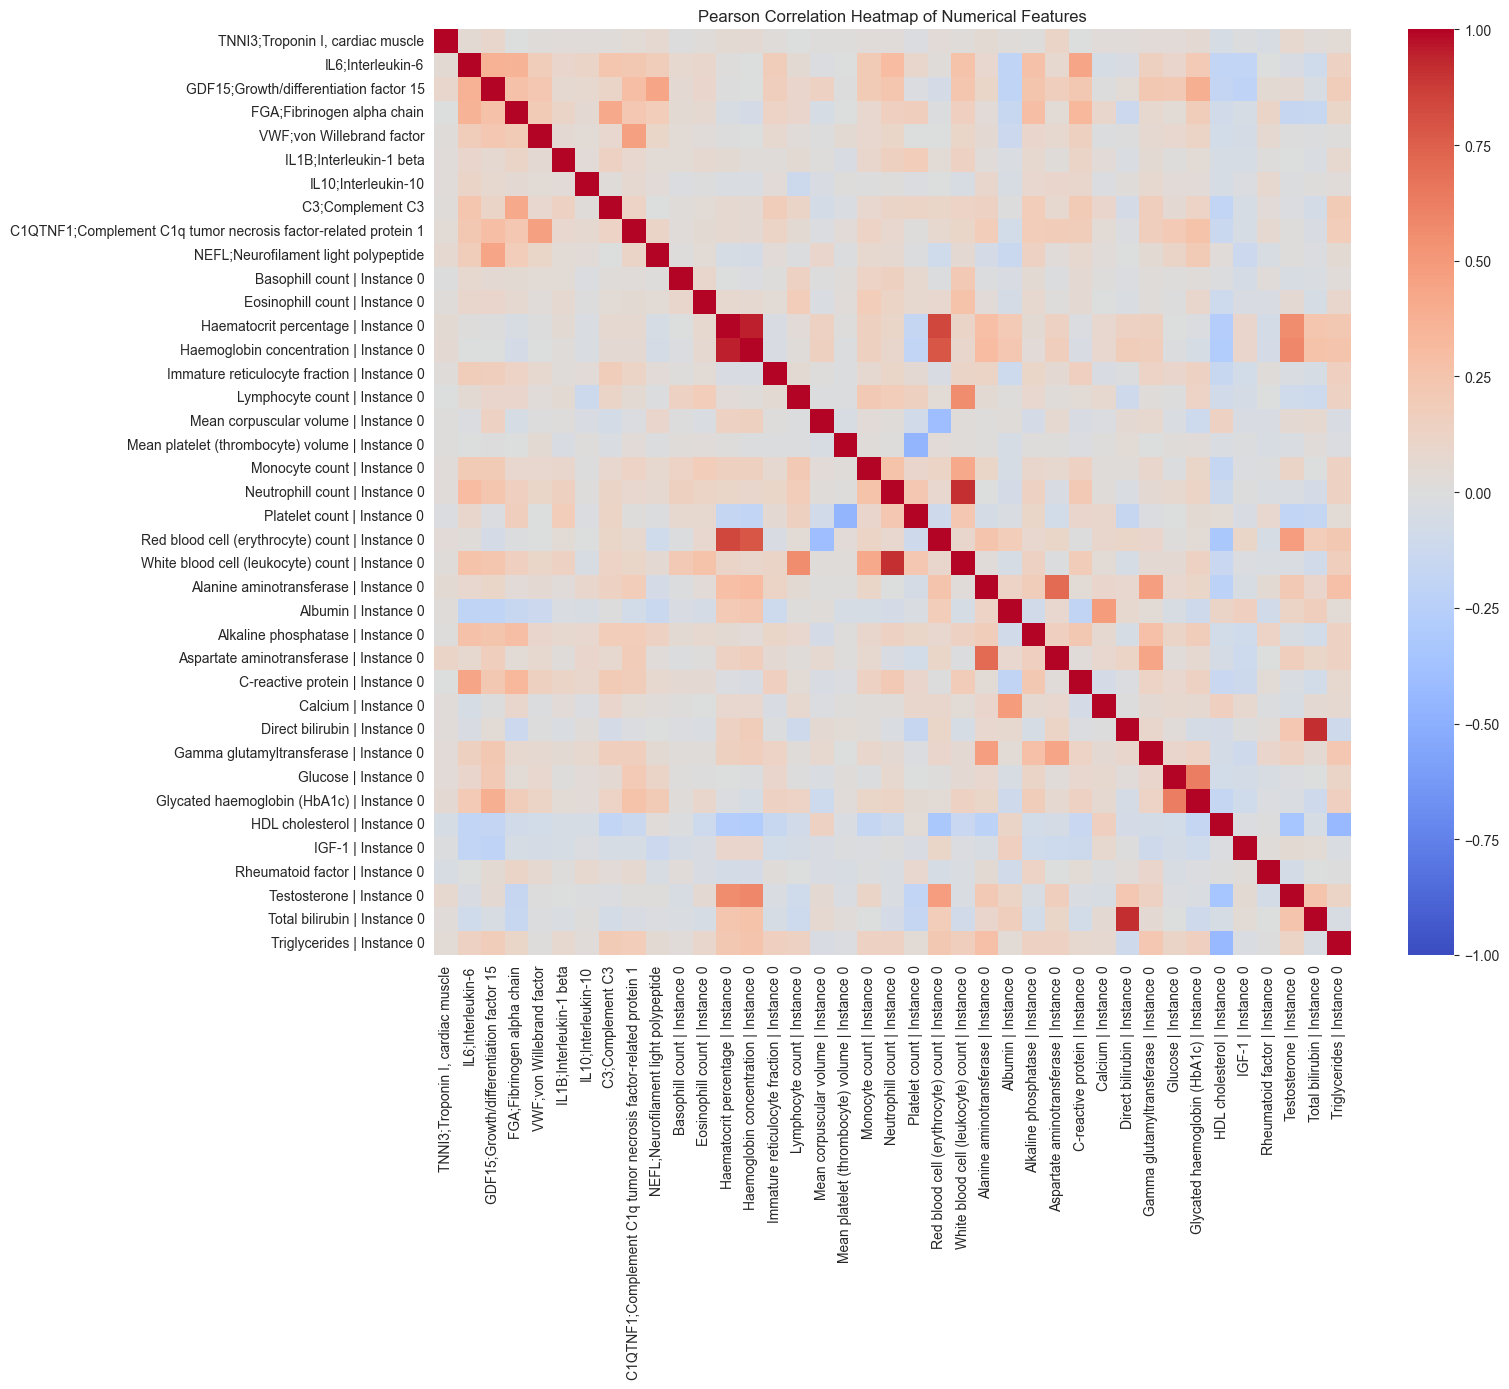

In [3]:
# Select numerical columns (excluding Participant ID)
numerical_columns = df.select_dtypes(include=[np.number]).columns.drop('Participant ID', errors='ignore')

# Compute Pearson correlation matrix
corr_matrix = df[numerical_columns].corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Pearson Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


In [4]:
# Prepare data for XGBoost - Binary Classification (Healthy vs Stroke)
X = df[numerical_columns].copy()

# Create binary labels: combine both stroke types into "Stroke"
y = df['label'].apply(lambda x: 'Healthy' if x == 'Healthy' else 'Stroke')

print("Binary Classification: Healthy vs Stroke")
print(f"\nOriginal class distribution:")
print(y.value_counts())

# Encode labels (0 = Healthy, 1 = Stroke)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data FIRST (before any preprocessing to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# ============== IMPROVEMENT 1: Handle Missing Values ==============
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# ============== IMPROVEMENT 2: Feature Scaling ==============
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# ============== IMPROVEMENT 3: SMOTE Oversampling ==============
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE resampling:")
print(f"  Healthy: {np.sum(y_train_resampled == 0)}")
print(f"  Stroke: {np.sum(y_train_resampled == 1)}")

# ============== IMPROVEMENT 4: Hyperparameter Tuning ==============
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

base_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

print("\nRunning hyperparameter search (this may take a minute)...")
random_search = RandomizedSearchCV(
    base_model, 
    param_dist, 
    n_iter=30,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=3),
    scoring='f1',  # Optimize for F1 score
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best CV F1 score: {random_search.best_score_:.4f}")

model = random_search.best_estimator_

print(f"\nTraining samples (after SMOTE): {len(X_train_resampled)}")
print(f"Test samples: {len(X_test_scaled)}")
print(f"Classes: {le.classes_}")


Binary Classification: Healthy vs Stroke

Original class distribution:
label
Healthy    6694
Stroke     1845
Name: count, dtype: int64

After SMOTE resampling:
  Healthy: 5355
  Stroke: 5355

Running hyperparameter search (this may take a minute)...


/Users/galle/PycharmProjects/UK-Biobank-Project/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [09:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/galle/PycharmProjects/UK-Biobank-Project/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [09:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/galle/PycharmProjects/UK-Biobank-Project/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [09:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/galle/PycharmProjects/UK-Biobank-Project/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [09


Best parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV F1 score: 0.8767

Training samples (after SMOTE): 10710
Test samples: 1708
Classes: ['Healthy' 'Stroke']


Optimal threshold: 0.36 (maximizes F1 score)


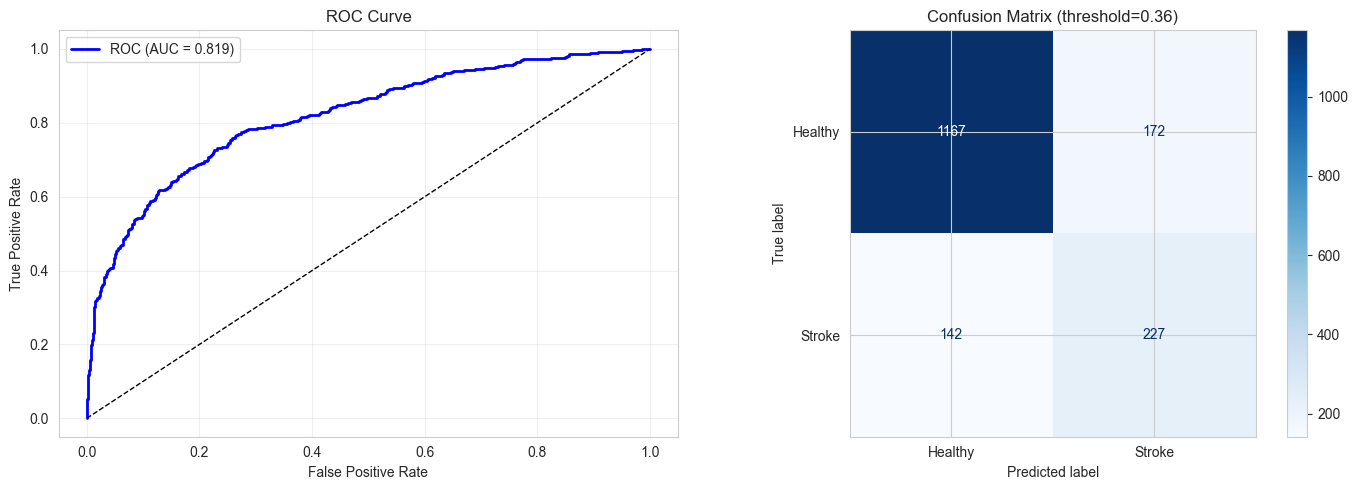


RESULTS WITH OPTIMIZED THRESHOLD
AUC-ROC: 0.8190
Accuracy: 81.62%

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.87      0.88      1339
      Stroke       0.57      0.62      0.59       369

    accuracy                           0.82      1708
   macro avg       0.73      0.74      0.74      1708
weighted avg       0.82      0.82      0.82      1708



In [5]:
# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# ============== IMPROVEMENT 5: Threshold Optimization ==============
# Find optimal threshold that maximizes F1 score
from sklearn.metrics import f1_score
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold:.2f} (maximizes F1 score)")

# Use optimal threshold for predictions
y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {auc_score:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion Matrix with optimized threshold
cm = confusion_matrix(y_test, y_pred_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', ax=axes[1])
axes[1].set_title(f'Confusion Matrix (threshold={optimal_threshold:.2f})')

plt.tight_layout()
plt.show()

# Print metrics
print(f"\n{'='*50}")
print("RESULTS WITH OPTIMIZED THRESHOLD")
print(f"{'='*50}")
print(f"AUC-ROC: {auc_score:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=le.classes_))


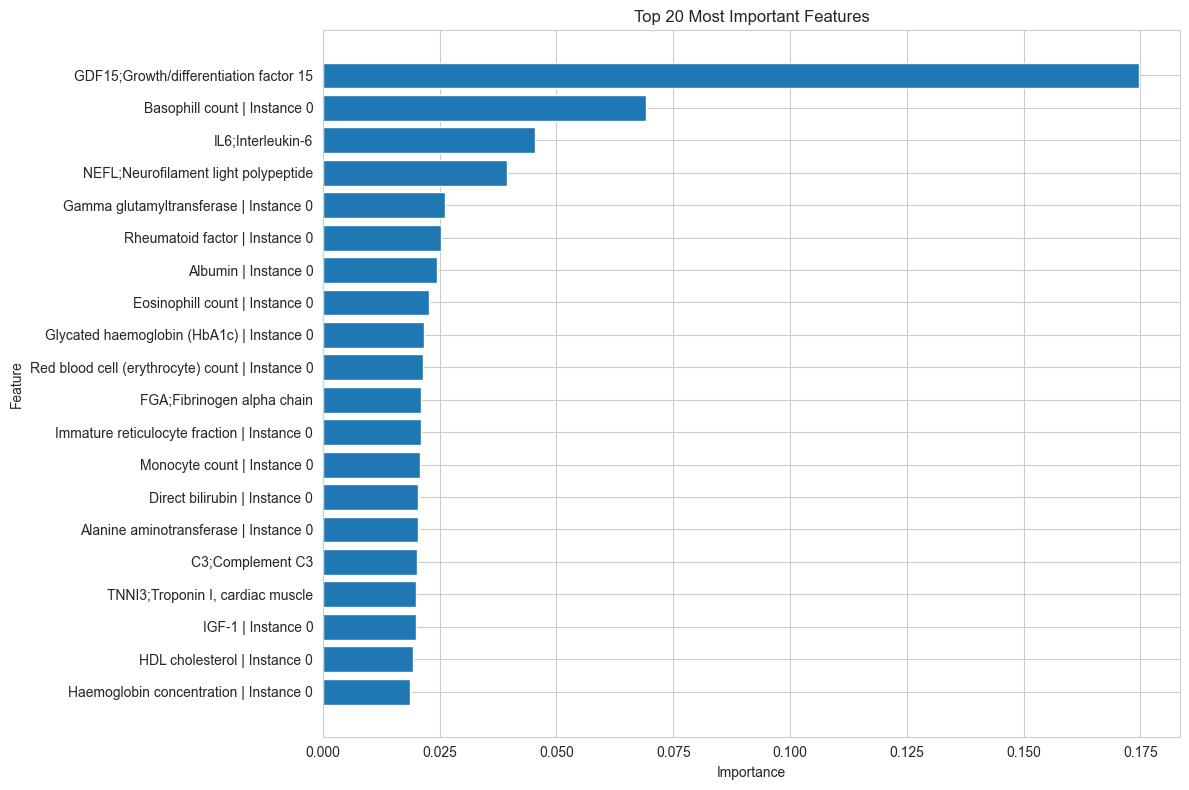


Top 10 most important features:
                                        feature  importance
         GDF15;Growth/differentiation factor 15    0.174735
                   Basophill count | Instance 0    0.069056
                              IL6;Interleukin-6    0.045356
           NEFL;Neurofilament light polypeptide    0.039324
         Gamma glutamyltransferase | Instance 0    0.026046
                 Rheumatoid factor | Instance 0    0.025254
                           Albumin | Instance 0    0.024422
                 Eosinophill count | Instance 0    0.022773
      Glycated haemoglobin (HbA1c) | Instance 0    0.021703
Red blood cell (erythrocyte) count | Instance 0    0.021517


In [6]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': numerical_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))

In [7]:
# ============== NEURAL NETWORK MODEL ==============
%pip install tensorflow -q

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
TensorFlow version: 2.20.0


In [8]:
# Build Neural Network Model
n_features = X_train_resampled.shape[1]

nn_model = keras.Sequential([
    # Input layer
    layers.Input(shape=(n_features,)),
    
    # Hidden layer 1
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Hidden layer 2
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Hidden layer 3
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

# Compile with class weights for imbalance
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

nn_model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
print("\nTraining Neural Network...")
history = nn_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,385 (64.00 KB)

 Trainable params: 15,937 (62.25 KB)

 Non-trainable params: 448 (1.75 KB)


Training Neural Network...
Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6674 - auc: 0.7255 - loss: 0.8115 - val_accuracy: 0.6769 - val_auc: 0.0000e+00 - val_loss: 0.7652 - learning_rate: 0.0010
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7515 - auc: 0.8103 - loss: 0.6885 - val_accuracy: 0.7479 - val_auc: 0.0000e+00 - val_loss: 0.6790 - learning_rate: 0.0010
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7764 - auc: 0.8334 - loss: 0.6505 - val_accuracy: 0.7554 - val_auc: 0.0000e+00 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7862 - auc: 0.8437 - loss: 0.6259 - val_accuracy: 0.7890 - val_auc: 0.0000e+00 - val_loss: 0.6176 - learning_rate: 0.0010
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7855 - auc: 0.8520 - loss: 0.6076 - val_accuracy: 0.7937 - val_auc: 0.0000e+00 - val_loss: 0.6044 - learning_rate: 0.0010
Epoch 6/100
134/134 ━━━━━━━

Neural Network optimal threshold: 0.50


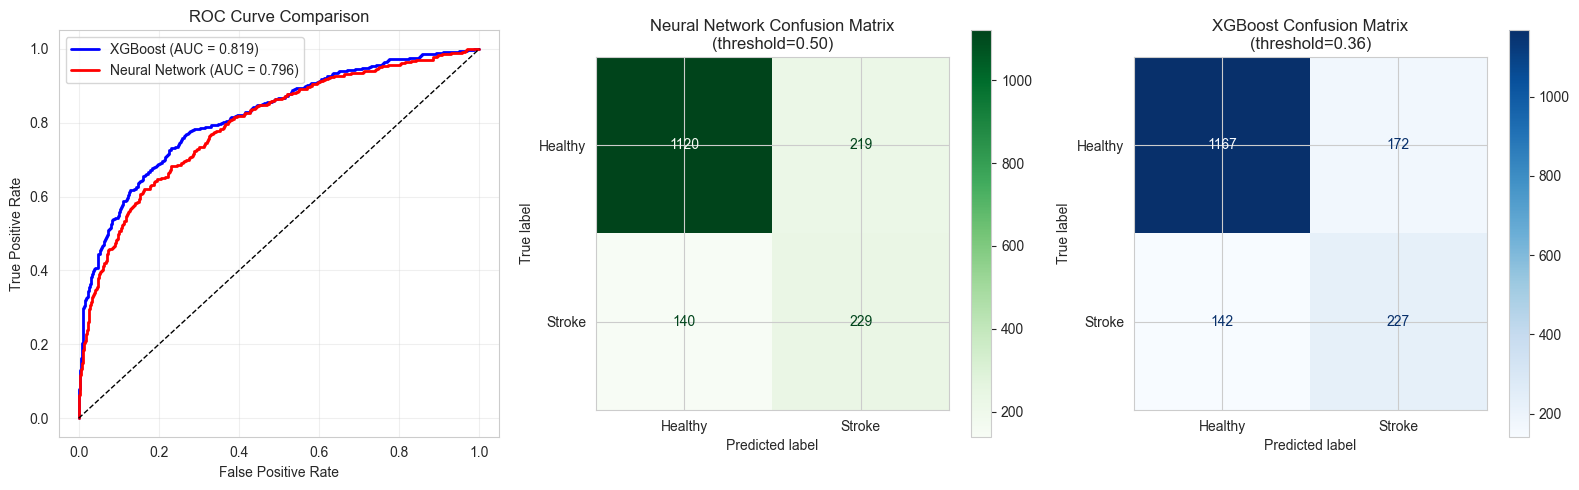


NEURAL NETWORK RESULTS
AUC-ROC: 0.7965
Accuracy: 78.98%

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.84      0.86      1339
      Stroke       0.51      0.62      0.56       369

    accuracy                           0.79      1708
   macro avg       0.70      0.73      0.71      1708
weighted avg       0.81      0.79      0.80      1708


MODEL COMPARISON SUMMARY
Metric               XGBoost         Neural Network 
--------------------------------------------------
AUC-ROC              0.8190          0.7965         
Accuracy             81.62%          78.98%         
F1 Score (Stroke)    0.5911          0.5606         


In [9]:
# Evaluate Neural Network
nn_pred_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()

# Find optimal threshold
nn_f1_scores = [f1_score(y_test, (nn_pred_proba >= t).astype(int)) for t in thresholds]
nn_optimal_threshold = thresholds[np.argmax(nn_f1_scores)]
print(f"Neural Network optimal threshold: {nn_optimal_threshold:.2f}")

# Predictions with optimal threshold
nn_pred = (nn_pred_proba >= nn_optimal_threshold).astype(int)

# ROC Curve
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_pred_proba)
nn_auc = roc_auc_score(y_test, nn_pred_proba)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ROC Curves comparison
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'XGBoost (AUC = {auc_score:.3f})')
axes[0].plot(nn_fpr, nn_tpr, 'r-', linewidth=2, label=f'Neural Network (AUC = {nn_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Neural Network Confusion Matrix
nn_cm = confusion_matrix(y_test, nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=le.classes_)
disp.plot(cmap='Greens', ax=axes[1])
axes[1].set_title(f'Neural Network Confusion Matrix\n(threshold={nn_optimal_threshold:.2f})')

# XGBoost Confusion Matrix (for comparison)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp2.plot(cmap='Blues', ax=axes[2])
axes[2].set_title(f'XGBoost Confusion Matrix\n(threshold={optimal_threshold:.2f})')

plt.tight_layout()
plt.show()

# Print Neural Network metrics
print(f"\n{'='*50}")
print("NEURAL NETWORK RESULTS")
print(f"{'='*50}")
print(f"AUC-ROC: {nn_auc:.4f}")
print(f"Accuracy: {accuracy_score(y_test, nn_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, nn_pred, target_names=le.classes_))

# Comparison summary
print(f"\n{'='*50}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*50}")
print(f"{'Metric':<20} {'XGBoost':<15} {'Neural Network':<15}")
print(f"{'-'*50}")
print(f"{'AUC-ROC':<20} {auc_score:<15.4f} {nn_auc:<15.4f}")
print(f"{'Accuracy':<20} {accuracy_score(y_test, y_pred_optimized):<15.2%} {accuracy_score(y_test, nn_pred):<15.2%}")
xgb_f1 = f1_score(y_test, y_pred_optimized)
nn_f1 = f1_score(y_test, nn_pred)
print(f"{'F1 Score (Stroke)':<20} {xgb_f1:<15.4f} {nn_f1:<15.4f}")


Healthy participants: 6694
Sick (Stroke) participants: 1845


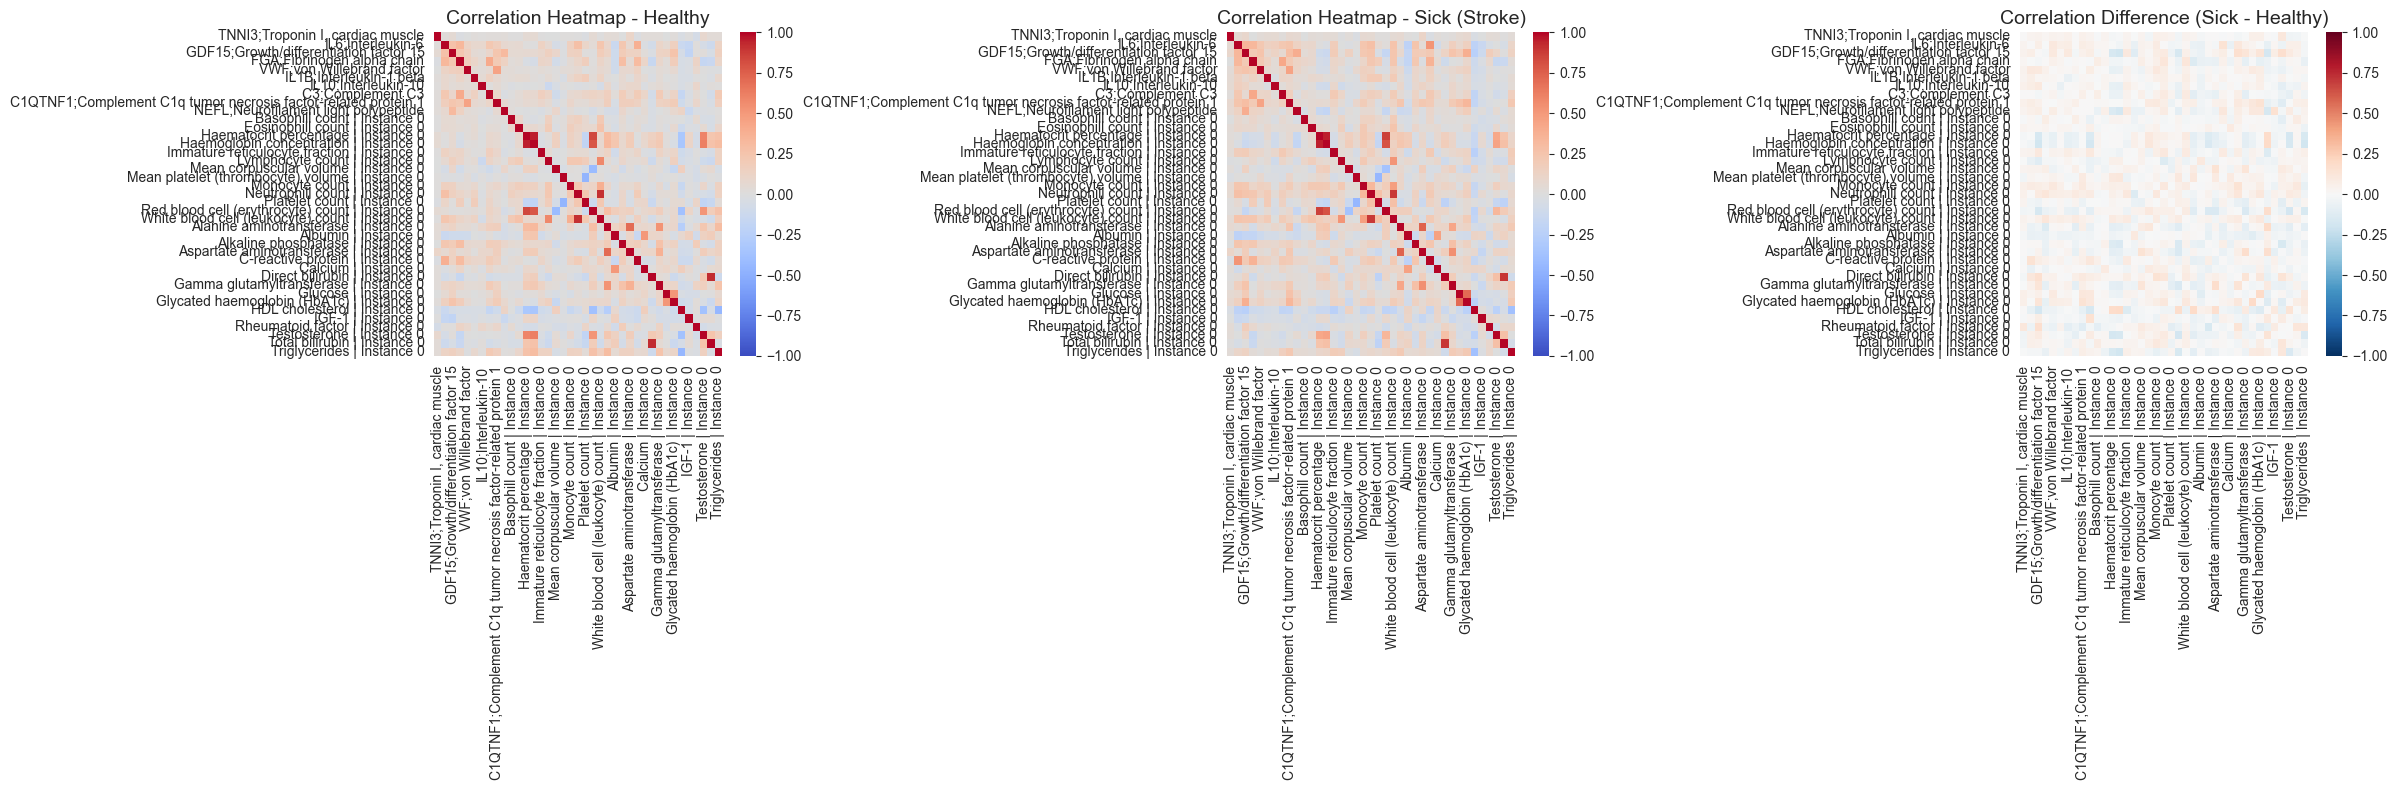


Filtering criteria: At least one group must have |correlation| >= 0.3
Pairs meeting criteria: 35 out of 741 total pairs

TOP 10 FEATURE PAIRS WITH HIGHEST MEANINGFUL CORRELATION DIFFERENCE (Sick - Healthy)

1. Glucose | Instance 0
   × Glycated haemoglobin (HbA1c) | Instance 0
   Healthy corr: +0.5146 | Sick corr: +0.7081 | Diff: +0.1935

2. Haemoglobin concentration | Instance 0
   × HDL cholesterol | Instance 0
   Healthy corr: -0.3385 | Sick corr: -0.1458 | Diff: +0.1927

3. Haemoglobin concentration | Instance 0
   × Triglycerides | Instance 0
   Healthy corr: +0.3010 | Sick corr: +0.1099 | Diff: -0.1911

4. Red blood cell (erythrocyte) count | Instance 0
   × Testosterone | Instance 0
   Healthy corr: +0.5214 | Sick corr: +0.3381 | Diff: -0.1832

5. Haematocrit percentage | Instance 0
   × HDL cholesterol | Instance 0
   Healthy corr: -0.3218 | Sick corr: -0.1417 | Diff: +0.1801

6. Aspartate aminotransferase | Instance 0
   × Gamma glutamyltransferase | Instance 0
   Healthy cor

In [10]:
# ============== CORRELATION DIFFERENCE ANALYSIS ==============
# Separate data into healthy and sick (stroke) groups
healthy_df = df[df['label'] == 'Healthy']
sick_df = df[df['label'] != 'Healthy']

print(f"Healthy participants: {len(healthy_df)}")
print(f"Sick (Stroke) participants: {len(sick_df)}")

# Calculate correlation matrices for each group
corr_healthy = healthy_df[numerical_columns].corr(method='pearson')
corr_sick = sick_df[numerical_columns].corr(method='pearson')

# Calculate the difference (Sick - Healthy)
corr_diff = corr_sick - corr_healthy

# Plot all three heatmaps
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Healthy heatmap
sns.heatmap(corr_healthy, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axes[0])
axes[0].set_title('Correlation Heatmap - Healthy', fontsize=14)

# Sick heatmap
sns.heatmap(corr_sick, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axes[1])
axes[1].set_title('Correlation Heatmap - Sick (Stroke)', fontsize=14)

# Difference heatmap
sns.heatmap(corr_diff, annot=False, cmap='RdBu_r', vmin=-1, vmax=1, center=0, ax=axes[2])
axes[2].set_title('Correlation Difference (Sick - Healthy)', fontsize=14)

plt.tight_layout()
plt.show()

# ============== TOP 10 PAIRS WITH HIGHEST CORRELATION DIFFERENCE ==============
# Minimum correlation threshold - at least one group must have |r| >= this value
# This ensures we only consider pairs where there's a meaningful correlation
MIN_CORRELATION_THRESHOLD = 0.3

# Get all pairs and their differences
pairs = []
for i in range(len(numerical_columns)):
    for j in range(i + 1, len(numerical_columns)):
        feat1 = numerical_columns[i]
        feat2 = numerical_columns[j]
        diff = corr_diff.iloc[i, j]
        corr_h = corr_healthy.iloc[i, j]
        corr_s = corr_sick.iloc[i, j]
        
        if np.isnan(diff):  # Skip NaN values
            continue
            
        # Check if at least one group has a meaningful correlation
        has_meaningful_corr = (abs(corr_h) >= MIN_CORRELATION_THRESHOLD or 
                               abs(corr_s) >= MIN_CORRELATION_THRESHOLD)
        
        if has_meaningful_corr:
            pairs.append({
                'Feature 1': feat1,
                'Feature 2': feat2,
                'Corr (Healthy)': corr_h,
                'Corr (Sick)': corr_s,
                'Difference': diff,
                'Abs Difference': abs(diff),
                'Max Abs Corr': max(abs(corr_h), abs(corr_s))
            })

# Create DataFrame and sort by absolute difference
pairs_df = pd.DataFrame(pairs)
pairs_df_sorted = pairs_df.sort_values('Abs Difference', ascending=False)

print(f"\nFiltering criteria: At least one group must have |correlation| >= {MIN_CORRELATION_THRESHOLD}")
print(f"Pairs meeting criteria: {len(pairs_df)} out of {len(numerical_columns) * (len(numerical_columns) - 1) // 2} total pairs")

# Display top 10 pairs
print("\n" + "="*90)
print("TOP 10 FEATURE PAIRS WITH HIGHEST MEANINGFUL CORRELATION DIFFERENCE (Sick - Healthy)")
print("="*90)
top_10 = pairs_df_sorted.head(10)
for rank, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"\n{rank}. {row['Feature 1']}")
    print(f"   × {row['Feature 2']}")
    print(f"   Healthy corr: {row['Corr (Healthy)']:+.4f} | Sick corr: {row['Corr (Sick)']:+.4f} | Diff: {row['Difference']:+.4f}")

# Also display as a formatted table
print("\n\nSummary Table:")
print(top_10[['Feature 1', 'Feature 2', 'Corr (Healthy)', 'Corr (Sick)', 'Difference']].to_string(index=False))


In [11]:
# ============== CREATE ADVANCED FEATURES FROM TOP CORRELATED PAIRS ==============
# The key insight: correlation DIFFERENCE between sick/healthy means the RELATIONSHIP
# between features is different. We want to capture this relationship.

from sklearn.linear_model import LinearRegression

N_TOP_PAIRS = 10
top_pairs = pairs_df_sorted.head(N_TOP_PAIRS)

# Create a copy of the dataframe
df_enhanced = df.copy()
new_feature_names = []

# Get healthy subset for fitting regression models
healthy_mask = df_enhanced['label'] == 'Healthy'

print(f"Creating advanced features from top {N_TOP_PAIRS} correlated pairs...\n")
print("Methods used:")
print("  1.  RESID:   Deviation from healthy-population regression line")
print("  2.  ZDIFF:   Difference in standardized z-scores")
print("  3.  ABSZD:   Absolute z-score difference (magnitude of discordance)")
print("  4.  SQZD:    Squared z-score difference (emphasizes large differences)")
print("  5.  ZSUM:    Sum of z-scores (jointly high/low)")
print("  6.  ZPROD:   Product of z-scores (same vs opposite direction)")
print("  7.  ZMAX:    Maximum absolute z-score (most extreme feature)")
print("  8.  ZDIST:   Euclidean distance from healthy center in 2D space")
print("  9.  INTER:   Interaction (centered product)")
print("  10. LOGR:    Log ratio (robust to skew)")
print("  11. RANKD:   Percentile rank difference (robust to outliers)")
print("  12. ABSRES:  Absolute residual (magnitude of deviation)")
print("="*80 + "\n")

for idx, row in top_pairs.iterrows():
    feat1 = row['Feature 1']
    feat2 = row['Feature 2']
    
    # Short names for feature naming
    f1_short = feat1.replace(' | Instance 0', '').replace(' | Instance 1', '')[:20]
    f2_short = feat2.replace(' | Instance 0', '').replace(' | Instance 1', '')[:20]
    
    # Get feature values
    x1 = df_enhanced[feat1].values
    x2 = df_enhanced[feat2].values
    
    # ==================== METHOD 1: RESIDUAL ====================
    # Fit regression on HEALTHY people only: predict feat1 from feat2
    # Then calculate residual for ALL samples
    # Sick people with different correlations will have systematic residuals
    
    healthy_x1 = df_enhanced.loc[healthy_mask, feat1].values.reshape(-1, 1)
    healthy_x2 = df_enhanced.loc[healthy_mask, feat2].values.reshape(-1, 1)
    
    # Remove NaN for fitting
    valid_healthy_mask = ~(np.isnan(healthy_x1.flatten()) | np.isnan(healthy_x2.flatten()))
    if valid_healthy_mask.sum() > 10:  # Need enough samples
        reg = LinearRegression()
        reg.fit(healthy_x2[valid_healthy_mask], healthy_x1[valid_healthy_mask])
        
        # Predict for ALL samples and calculate residual (handle NaN)
        residual = np.full(len(df_enhanced), np.nan)  # Initialize with NaN
        all_valid_mask = ~(np.isnan(x1) | np.isnan(x2))  # Valid samples in full data
        
        if all_valid_mask.sum() > 0:
            all_x2_valid = x2[all_valid_mask].reshape(-1, 1)
            predicted = reg.predict(all_x2_valid).flatten()
            residual[all_valid_mask] = x1[all_valid_mask] - predicted
        
        residual_name = f"RESID_{f1_short}_from_{f2_short}"
        df_enhanced[residual_name] = residual
        new_feature_names.append(residual_name)
    
    # ==================== METHOD 2: Z-SCORE DIFFERENCE ====================
    # Standardize both features and take the difference
    # Captures when someone's relative position differs between two measurements
    
    # Use healthy population statistics for standardization
    mean1_h = df_enhanced.loc[healthy_mask, feat1].mean()
    std1_h = df_enhanced.loc[healthy_mask, feat1].std()
    mean2_h = df_enhanced.loc[healthy_mask, feat2].mean()
    std2_h = df_enhanced.loc[healthy_mask, feat2].std()
    
    if std1_h > 0 and std2_h > 0:
        z1 = (x1 - mean1_h) / std1_h
        z2 = (x2 - mean2_h) / std2_h
        
        # Z-score difference
        z_diff = z1 - z2
        zdiff_name = f"ZDIFF_{f1_short}_vs_{f2_short}"
        df_enhanced[zdiff_name] = z_diff
        new_feature_names.append(zdiff_name)
        
        # ==================== METHOD 3: ABSOLUTE Z-DIFFERENCE ====================
        # |z1 - z2| - magnitude of discordance between features
        abs_zdiff = np.abs(z1 - z2)
        abs_zdiff_name = f"ABSZD_{f1_short}_vs_{f2_short}"
        df_enhanced[abs_zdiff_name] = abs_zdiff
        new_feature_names.append(abs_zdiff_name)
        
        # ==================== METHOD 4: SQUARED Z-DIFFERENCE ====================
        # (z1 - z2)^2 - emphasizes larger differences
        sq_zdiff = (z1 - z2) ** 2
        sq_zdiff_name = f"SQZD_{f1_short}_vs_{f2_short}"
        df_enhanced[sq_zdiff_name] = sq_zdiff
        new_feature_names.append(sq_zdiff_name)
        
        # ==================== METHOD 5: Z-SCORE SUM ====================
        # z1 + z2 - captures when both features are jointly high or low
        z_sum = z1 + z2
        zsum_name = f"ZSUM_{f1_short}_plus_{f2_short}"
        df_enhanced[zsum_name] = z_sum
        new_feature_names.append(zsum_name)
        
        # ==================== METHOD 6: Z-SCORE PRODUCT ====================
        # z1 * z2 - positive when both same direction, negative when opposite
        z_prod = z1 * z2
        zprod_name = f"ZPROD_{f1_short}_x_{f2_short}"
        df_enhanced[zprod_name] = z_prod
        new_feature_names.append(zprod_name)
        
        # ==================== METHOD 7: MAX Z-SCORE ====================
        # max(|z1|, |z2|) - which feature is more extreme
        z_max = np.maximum(np.abs(z1), np.abs(z2))
        zmax_name = f"ZMAX_{f1_short}_vs_{f2_short}"
        df_enhanced[zmax_name] = z_max
        new_feature_names.append(zmax_name)
        
        # ==================== METHOD 8: EUCLIDEAN DISTANCE FROM HEALTHY CENTER ====================
        # sqrt(z1^2 + z2^2) - distance from healthy population center in 2D space
        z_dist = np.sqrt(z1**2 + z2**2)
        zdist_name = f"ZDIST_{f1_short}_vs_{f2_short}"
        df_enhanced[zdist_name] = z_dist
        new_feature_names.append(zdist_name)
    
    # ==================== METHOD 9: INTERACTION (Centered Product) ====================
    # Product of mean-centered values: (x1 - mean1) * (x2 - mean2)
    # This is similar to what goes into correlation calculation
    # Captures joint deviation from expected values
    
    x1_centered = x1 - mean1_h
    x2_centered = x2 - mean2_h
    interaction = x1_centered * x2_centered
    
    interact_name = f"INTER_{f1_short}_x_{f2_short}"
    df_enhanced[interact_name] = interaction
    new_feature_names.append(interact_name)
    
    # ==================== METHOD 10: LOG RATIO (for positive values) ====================
    # log(feat1 / feat2) - better than raw ratio for skewed data
    # Only for samples where both values are positive
    min_val = 1e-10  # Small value to avoid log(0)
    x1_pos = np.where(x1 > 0, x1, np.nan)
    x2_pos = np.where(x2 > 0, x2, np.nan)
    log_ratio = np.log(x1_pos / x2_pos)
    log_ratio = np.where(np.isinf(log_ratio), np.nan, log_ratio)  # Handle inf
    
    logratio_name = f"LOGR_{f1_short}_div_{f2_short}"
    df_enhanced[logratio_name] = log_ratio
    new_feature_names.append(logratio_name)
    
    # ==================== METHOD 11: RANK DIFFERENCE ====================
    # rank(feat1) - rank(feat2) - robust to outliers, captures relative ordering
    rank1 = df_enhanced[feat1].rank(pct=True)  # Percentile rank
    rank2 = df_enhanced[feat2].rank(pct=True)
    rank_diff = rank1 - rank2
    
    rankdiff_name = f"RANKD_{f1_short}_vs_{f2_short}"
    df_enhanced[rankdiff_name] = rank_diff
    new_feature_names.append(rankdiff_name)
    
    # ==================== METHOD 12: ABSOLUTE RESIDUAL ====================
    # |residual| - magnitude of deviation from expected relationship
    if f"RESID_{f1_short}_from_{f2_short}" in df_enhanced.columns:
        abs_resid = np.abs(df_enhanced[f"RESID_{f1_short}_from_{f2_short}"])
        abs_resid_name = f"ABSRES_{f1_short}_from_{f2_short}"
        df_enhanced[abs_resid_name] = abs_resid
        new_feature_names.append(abs_resid_name)
    
    print(f"✓ Pair: {feat1[:40]}...")
    print(f"       × {feat2[:40]}...")

# Summary
print("\n" + "="*80)
print(f"FEATURE ENGINEERING COMPLETE")
print("="*80)
print(f"Original features: {len(df.columns)}")
print(f"New engineered features: {len(new_feature_names)}")

# Count by type
feature_types = {
    'RESID': 'Residual',
    'ZDIFF': 'Z-score Difference', 
    'ABSZD': 'Absolute Z-Diff',
    'SQZD': 'Squared Z-Diff',
    'ZSUM': 'Z-score Sum',
    'ZPROD': 'Z-score Product',
    'ZMAX': 'Max Z-score',
    'ZDIST': 'Z-distance',
    'INTER': 'Interaction',
    'LOGR': 'Log Ratio',
    'RANKD': 'Rank Difference',
    'ABSRES': 'Absolute Residual'
}

print("\nBreakdown by method:")
for prefix, name in feature_types.items():
    count = len([f for f in new_feature_names if f.startswith(prefix)])
    if count > 0:
        print(f"  - {name} ({prefix}): {count}")

print(f"\nTotal features in df_enhanced: {len(df_enhanced.columns)}")

# Update numerical_columns to include new features
numerical_columns_enhanced = df_enhanced.select_dtypes(include=[np.number]).columns.drop('Participant ID', errors='ignore')
print(f"Numerical columns available for training: {len(numerical_columns_enhanced)}")


Creating advanced features from top 10 correlated pairs...

Methods used:
  1.  RESID:   Deviation from healthy-population regression line
  2.  ZDIFF:   Difference in standardized z-scores
  3.  ABSZD:   Absolute z-score difference (magnitude of discordance)
  4.  SQZD:    Squared z-score difference (emphasizes large differences)
  5.  ZSUM:    Sum of z-scores (jointly high/low)
  6.  ZPROD:   Product of z-scores (same vs opposite direction)
  7.  ZMAX:    Maximum absolute z-score (most extreme feature)
  8.  ZDIST:   Euclidean distance from healthy center in 2D space
  9.  INTER:   Interaction (centered product)
  10. LOGR:    Log ratio (robust to skew)
  11. RANKD:   Percentile rank difference (robust to outliers)
  12. ABSRES:  Absolute residual (magnitude of deviation)

✓ Pair: Glucose | Instance 0...
       × Glycated haemoglobin (HbA1c) | Instance ...
✓ Pair: Haemoglobin concentration | Instance 0...
       × HDL cholesterol | Instance 0...
✓ Pair: Haemoglobin concentration | In

/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_82079/3555509157.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enhanced[zdiff_name] = z_diff
/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_82079/3555509157.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enhanced[abs_zdiff_name] = abs_zdiff
/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_82079/3555509157.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

Training with 159 features (including 120 new engineered features)
Training samples (after SMOTE): 10710


/Users/galle/PycharmProjects/UK-Biobank-Project/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [09:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



MODEL COMPARISON: ORIGINAL vs ENHANCED (with ratio features)
Metric                    Original XGBoost     Enhanced XGBoost    
----------------------------------------------------------------------
Features                  39                   159                 
AUC-ROC                   0.8190               0.8241              
Accuracy                  81.62%               83.26%              
F1 Score (Stroke)         0.5911               0.6039              
----------------------------------------------------------------------
AUC Improvement           +0.0051
F1 Improvement            +0.0127


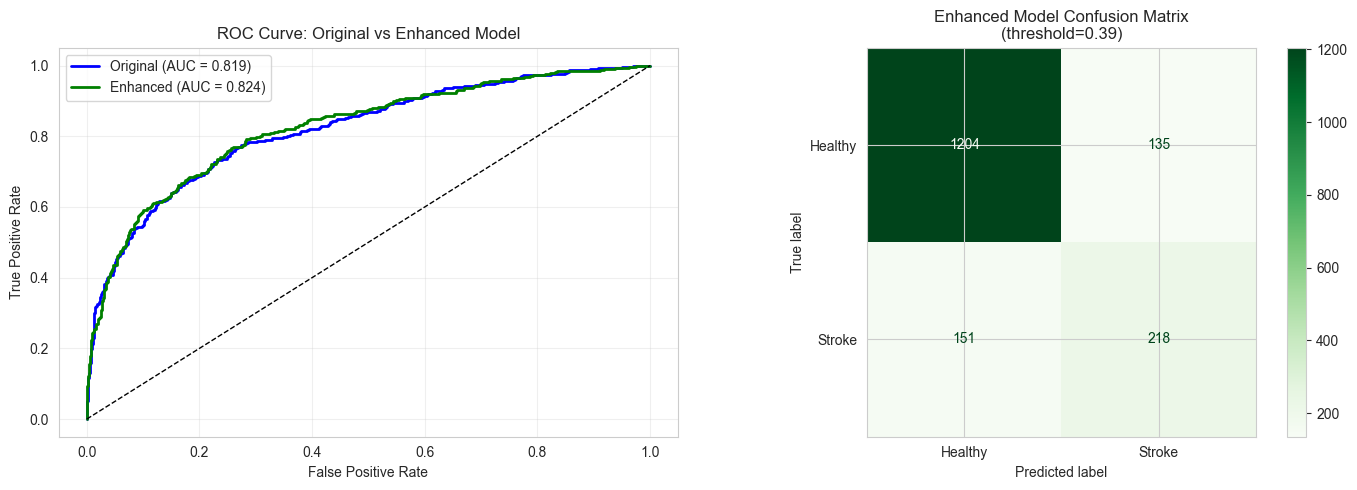

In [12]:
# ============== TRAIN MODEL WITH ENHANCED FEATURES ==============
# Prepare data with the new ratio features
X_enhanced = df_enhanced[numerical_columns_enhanced].copy()

# Create binary labels
y_enhanced = df_enhanced['label'].apply(lambda x: 'Healthy' if x == 'Healthy' else 'Stroke')
y_enhanced_encoded = le.fit_transform(y_enhanced)

# Split data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced_encoded, test_size=0.2, random_state=42, stratify=y_enhanced_encoded
)

# Impute missing values (including new ratio features that might have NaN from division)
imputer_enh = SimpleImputer(strategy='median')
X_train_enh_imputed = imputer_enh.fit_transform(X_train_enh)
X_test_enh_imputed = imputer_enh.transform(X_test_enh)

# Scale features
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh_imputed)
X_test_enh_scaled = scaler_enh.transform(X_test_enh_imputed)

# Apply SMOTE
smote_enh = SMOTE(random_state=42)
X_train_enh_resampled, y_train_enh_resampled = smote_enh.fit_resample(X_train_enh_scaled, y_train_enh)

print(f"Training with {len(numerical_columns_enhanced)} features (including {len(new_feature_names)} new engineered features)")
print(f"Training samples (after SMOTE): {len(X_train_enh_resampled)}")

# Train XGBoost with same best parameters from original model
model_enhanced = XGBClassifier(
    **random_search.best_params_,
    random_state=42, 
    eval_metric='logloss', 
    use_label_encoder=False
)
model_enhanced.fit(X_train_enh_resampled, y_train_enh_resampled)

# Predictions
y_pred_proba_enh = model_enhanced.predict_proba(X_test_enh_scaled)[:, 1]

# Find optimal threshold
f1_scores_enh = [f1_score(y_test_enh, (y_pred_proba_enh >= t).astype(int)) for t in thresholds]
optimal_threshold_enh = thresholds[np.argmax(f1_scores_enh)]
y_pred_enh = (y_pred_proba_enh >= optimal_threshold_enh).astype(int)

# Calculate metrics
auc_enhanced = roc_auc_score(y_test_enh, y_pred_proba_enh)
acc_enhanced = accuracy_score(y_test_enh, y_pred_enh)
f1_enhanced = f1_score(y_test_enh, y_pred_enh)

# Compare with original model
print("\n" + "="*70)
print("MODEL COMPARISON: ORIGINAL vs ENHANCED (with ratio features)")
print("="*70)
print(f"{'Metric':<25} {'Original XGBoost':<20} {'Enhanced XGBoost':<20}")
print("-"*70)
print(f"{'Features':<25} {len(numerical_columns):<20} {len(numerical_columns_enhanced):<20}")
print(f"{'AUC-ROC':<25} {auc_score:<20.4f} {auc_enhanced:<20.4f}")
print(f"{'Accuracy':<25} {accuracy_score(y_test, y_pred_optimized):<20.2%} {acc_enhanced:<20.2%}")
print(f"{'F1 Score (Stroke)':<25} {xgb_f1:<20.4f} {f1_enhanced:<20.4f}")
print("-"*70)

# Improvement
auc_diff = auc_enhanced - auc_score
f1_diff = f1_enhanced - xgb_f1
print(f"{'AUC Improvement':<25} {auc_diff:+.4f}")
print(f"{'F1 Improvement':<25} {f1_diff:+.4f}")

# Plot ROC comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
fpr_enh, tpr_enh, _ = roc_curve(y_test_enh, y_pred_proba_enh)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'Original (AUC = {auc_score:.3f})')
axes[0].plot(fpr_enh, tpr_enh, 'g-', linewidth=2, label=f'Enhanced (AUC = {auc_enhanced:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve: Original vs Enhanced Model')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion Matrix for Enhanced Model
cm_enh = confusion_matrix(y_test_enh, y_pred_enh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_enh, display_labels=le.classes_)
disp.plot(cmap='Greens', ax=axes[1])
axes[1].set_title(f'Enhanced Model Confusion Matrix\n(threshold={optimal_threshold_enh:.2f})')

plt.tight_layout()
plt.show()


In [ ]:
# ============== TRANSFORMER NEURAL NETWORK FOR TABULAR DATA ==============
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import time

print("="*70)
print("Training Transformer Neural Network for Tabular Data")
print("="*70)

# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============== DEFINE TRANSFORMER MODEL ==============
class TabularTransformer(nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()
        
        # Feature embedding: project each feature to d_model dimensions
        self.feature_embedding = nn.Linear(1, d_model)
        
        # Positional encoding for features
        self.pos_encoding = nn.Parameter(torch.randn(1, n_features, d_model) * 0.1)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads, 
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model * n_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape: (batch, features) -> (batch, features, 1)
        x = x.unsqueeze(-1)
        
        # Embed each feature: (batch, features, 1) -> (batch, features, d_model)
        x = self.feature_embedding(x)
        
        # Add positional encoding
        x = x + self.pos_encoding
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Flatten and classify
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x.squeeze(-1)

# ============== PREPARE DATA ==============
n_features = X_train_enh_resampled.shape[1]
print(f"\nDataset: {len(X_train_enh_resampled)} train, {len(X_test_enh_scaled)} test, {n_features} features")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_enh_resampled).to(device)
y_train_tensor = torch.FloatTensor(y_train_enh_resampled).to(device)
X_test_tensor = torch.FloatTensor(X_test_enh_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_enh).to(device)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# ============== INITIALIZE MODEL ==============
model = TabularTransformer(
    n_features=n_features,
    d_model=64,
    n_heads=4,
    n_layers=3,
    dropout=0.3
).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============== TRAINING ==============
n_epochs = 50
best_val_auc = 0
patience_counter = 0
early_stop_patience = 10

print("\n[Training]", flush=True)
print(f"  Epochs: {n_epochs}, Early stopping patience: {early_stop_patience}", flush=True)
print(f"  Batches per epoch: {len(train_loader)}", flush=True)
print("-" * 60, flush=True)

train_start = time.time()

for epoch in range(n_epochs):
    epoch_start = time.time()
    model.train()
    epoch_loss = 0
    
    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_proba = model(X_test_tensor).cpu().numpy()
        val_auc = roc_auc_score(y_test_enh, val_proba)
    
    scheduler.step(1 - val_auc)  # Reduce LR on plateau
    
    avg_loss = epoch_loss / len(train_loader)
    epoch_time = time.time() - epoch_start
    
    # Early stopping check
    improved = ""
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        improved = " ⬆️ (best)"
    else:
        patience_counter += 1
    
    # Print progress every epoch
    print(f"  Epoch {epoch+1:3d}/{n_epochs} | Loss: {avg_loss:.4f} | Val AUC: {val_auc:.4f}{improved} | Time: {epoch_time:.1f}s | Patience: {patience_counter}/{early_stop_patience}", flush=True)
    
    if patience_counter >= early_stop_patience:
        print(f"\n  ⚠️ Early stopping triggered at epoch {epoch+1}", flush=True)
        break

train_time = time.time() - train_start
print(f"\n✓ Training completed in {train_time:.2f}s")

# Load best model
model.load_state_dict(best_model_state)

# ============== EVALUATION ==============
print("\n[Evaluation]")
model.eval()
with torch.no_grad():
    transformer_pred_proba = model(X_test_tensor).cpu().numpy()

# Find optimal threshold
transformer_f1_scores = [f1_score(y_test_enh, (transformer_pred_proba >= t).astype(int)) for t in thresholds]
transformer_optimal_threshold = thresholds[np.argmax(transformer_f1_scores)]
transformer_pred = (transformer_pred_proba >= transformer_optimal_threshold).astype(int)

# Calculate metrics
transformer_auc = roc_auc_score(y_test_enh, transformer_pred_proba)
transformer_acc = accuracy_score(y_test_enh, transformer_pred)
transformer_f1 = f1_score(y_test_enh, transformer_pred)

print(f"\nTransformer Results:")
print(f"  Optimal threshold: {transformer_optimal_threshold:.2f}")
print(f"  AUC-ROC: {transformer_auc:.4f}")
print(f"  Accuracy: {transformer_acc:.2%}")
print(f"  F1 Score (Stroke): {transformer_f1:.4f}")


Training Transformer Neural Network for Tabular Data
Using device: mps

Dataset: 10710 train, 1708 test, 159 features


In [ ]:
# ============== COMPARE ALL MODELS ==============
print("\n" + "="*80)
print("MODEL COMPARISON: Original XGBoost vs Enhanced XGBoost vs Transformer")
print("="*80)
print(f"{'Metric':<25} {'Original XGB':<18} {'Enhanced XGB':<18} {'Transformer':<18}")
print("-"*80)
print(f"{'Features':<25} {len(numerical_columns):<18} {len(numerical_columns_enhanced):<18} {len(numerical_columns_enhanced):<18}")
print(f"{'AUC-ROC':<25} {auc_score:<18.4f} {auc_enhanced:<18.4f} {transformer_auc:<18.4f}")
print(f"{'Accuracy':<25} {accuracy_score(y_test, y_pred_optimized):<18.2%} {acc_enhanced:<18.2%} {transformer_acc:<18.2%}")
print(f"{'F1 Score (Stroke)':<25} {xgb_f1:<18.4f} {f1_enhanced:<18.4f} {transformer_f1:<18.4f}")
print("-"*80)

# Highlight best model
all_aucs = [auc_score, auc_enhanced, transformer_auc]
all_f1s = [xgb_f1, f1_enhanced, transformer_f1]
model_names = ["Original XGB", "Enhanced XGB", "Transformer"]

best_auc_idx = np.argmax(all_aucs)
best_f1_idx = np.argmax(all_f1s)

print(f"🏆 Best AUC-ROC: {model_names[best_auc_idx]} ({all_aucs[best_auc_idx]:.4f})")
print(f"🏆 Best F1 Score: {model_names[best_f1_idx]} ({all_f1s[best_f1_idx]:.4f})")

# Plot ROC curves for all models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves comparison
transformer_fpr, transformer_tpr, _ = roc_curve(y_test_enh, transformer_pred_proba)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'Original XGBoost (AUC = {auc_score:.3f})')
axes[0].plot(fpr_enh, tpr_enh, 'g-', linewidth=2, label=f'Enhanced XGBoost (AUC = {auc_enhanced:.3f})')
axes[0].plot(transformer_fpr, transformer_tpr, 'r-', linewidth=2, label=f'Transformer (AUC = {transformer_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve Comparison: All Models')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Transformer Confusion Matrix
transformer_cm = confusion_matrix(y_test_enh, transformer_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=transformer_cm, display_labels=le.classes_)
disp.plot(cmap='Reds', ax=axes[1])
axes[1].set_title(f'Transformer Confusion Matrix\n(threshold={transformer_optimal_threshold:.2f})')

plt.tight_layout()
plt.show()

# Classification report for Transformer
print("\nTransformer Classification Report:")
print(classification_report(y_test_enh, transformer_pred, target_names=le.classes_))
